C:\Users\rukhm\AppData\Local\Temp\ipykernel_33344\2601549573.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Handling missing values


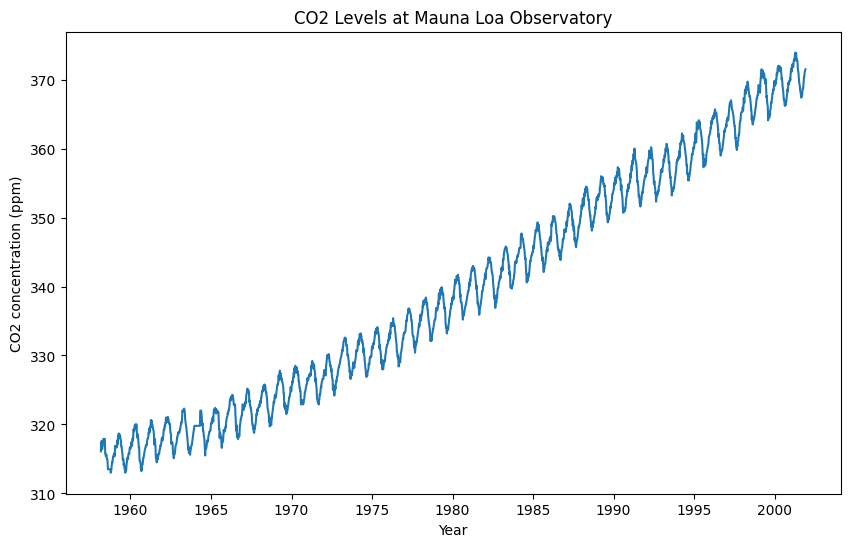

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import statsmodels.api as sm

# Load the dataset
data = sm.datasets.co2.load_pandas().data
data.fillna(method='ffill', inplace=True)  # Handling missing values
data['date'] = pd.date_range(start='1958-03', periods=len(data), freq='W-SAT')
data.set_index('date', inplace=True)

# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.plot(data['co2'])
plt.title('CO2 Levels at Mauna Loa Observatory')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('Year')
plt.show()

# Preprocess the data: Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['co2'].values.reshape(-1, 1))

In [16]:
print(scaled_data[0:3,0])
print(scaled_data[3,0])
print(scaled_data[0:4,0])

[0.05090312 0.07060755 0.07553366]
0.07389162561576335
[0.05090312 0.07060755 0.07553366 0.07389163]


In [ ]:
# Define the create_dataset function
def create_dataset(dataset, look_back=3): #takes the first n values as X and next value as Y
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10  # Use last week's CO2 levels to predict the current week
X, y = create_dataset(scaled_data, look_back)

# Split the data into training and testing datasets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(train_X, train_y, epochs=10, batch_size=1, verbose=2)

c:\anaconda\envs\dwwshop\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1522/1522 - 15s - 10ms/step - loss: 0.0071
Epoch 2/10
1522/1522 - 8s - 6ms/step - loss: 3.0844e-04
Epoch 3/10
1522/1522 - 11s - 7ms/step - loss: 2.2512e-04
Epoch 4/10
1522/1522 - 9s - 6ms/step - loss: 1.6663e-04
Epoch 5/10
1522/1522 - 7s - 5ms/step - loss: 1.4818e-04
Epoch 6/10
1522/1522 - 8s - 5ms/step - loss: 1.3809e-04
Epoch 7/10
1522/1522 - 8s - 5ms/step - loss: 1.2281e-04
Epoch 8/10
1522/1522 - 10s - 7ms/step - loss: 1.2949e-04
Epoch 9/10
1522/1522 - 9s - 6ms/step - loss: 1.1339e-04
Epoch 10/10
1522/1522 - 8s - 5ms/step - loss: 1.1577e-04


In [23]:
# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])

# Calculate root mean squared error
trainScore = np.sqrt(np.mean((train_predict - train_y) ** 2))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(np.mean((test_predict - test_y) ** 2))
print('Test Score: %.2f RMSE' % (testScore))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Train Score: 14.23 RMSE
Test Score: 9.09 RMSE


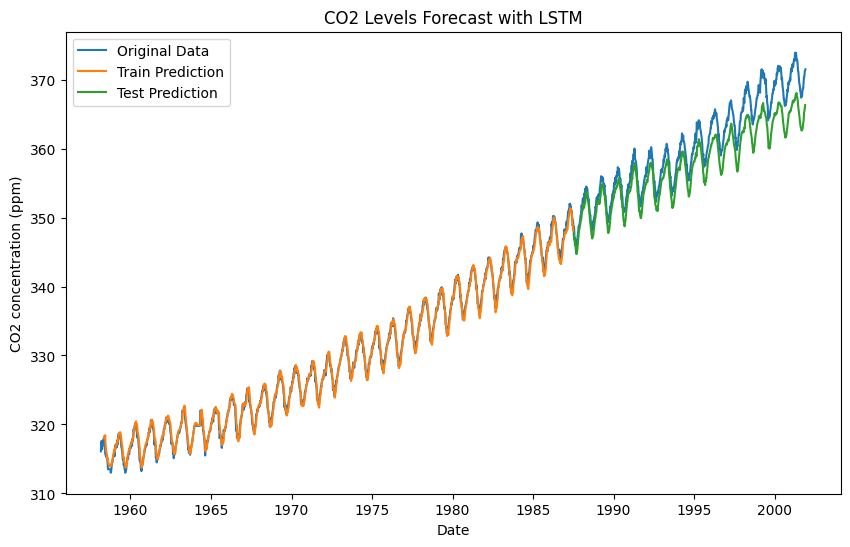

In [24]:
# Extract dates for the predictions
dates = data.index

plt.figure(figsize=(10, 6))

# Plot original dataset
plt.plot(dates, scaler.inverse_transform(scaled_data), label='Original Data')

# Plot training predictions
# Here we exclude the first `look_back` data points because the first prediction requires `look_back` points
train_dates = dates[look_back:train_size + look_back]
plt.plot(train_dates, train_predict, label='Train Prediction')

# Plot test predictions
# Adjusted test_dates to match the length of test_predict
test_dates = dates[train_size + look_back:train_size + look_back + len(test_predict)]
plt.plot(test_dates, test_predict, label='Test Prediction')

plt.title('CO2 Levels Forecast with LSTM')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
import plotly.express as px

num_future = 10  # Number of future predictions
last_data = scaled_data[-look_back:] #last look back no of elements

future_predictions = []

# Generate future predictions
for _ in range(num_future):
    x_input = last_data.reshape((1, 1, look_back))
    yhat = model.predict(x_input)
    future_predictions.append(yhat[0, 0])
    last_data = np.append(last_data, yhat)[1:]

# Inverse transform predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
print(future_predictions)

# Create a DataFrame for future predictions
future_dates = pd.date_range(start=data.index[-1], periods=num_future + 1, freq='W-SAT')[1:]
df_future = pd.DataFrame({"date": future_dates, "co2": future_predictions.flatten()})
df_future["Type"] = "Prediction"

# Add a column to the historical data
data["Type"] = "Historical"

# Combine historical and future data
df_combined = pd.concat([data.reset_index(), df_future]).reset_index(drop=True)
print(df_combined)

# Plot using Plotly
fig = px.line(
    df_combined,
    x="date",
    y="co2",
    color="Type",
    title="CO2 Levels with Forecast",
    color_discrete_map={"Historical": "blue", "Prediction": "red"},
)
fig.show()


In [ ]:
# Plot the combined data
fig = px.line(df_combined, x=df_combined.index, y='co2', title="CO2 Levels with Forecast")
fig.show()


## trying to understand the code

In [1]:
def create_dataset(dataset, look_back=3):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

dataset = np.array([[1], [2], [3], [4], [5]])
look_back = 3

Execution

First iteration (i=0):
a = dataset[0:3, 0] = [1, 2, 3] → X.append([1, 2, 3])
Y.append(dataset[3, 0]) = Y.append(4)

Second iteration (i=1):
a = dataset[1:4, 0] = [2, 3, 4] → X.append([2, 3, 4])
Y.append(dataset[4, 0]) = Y.append(5)